 <img src="storage/tf-logo-transparent.png" width=100 align="right">
 <div style="font-size: large;"><b>Group Work</b> - Machine Learning II</div><br>
 <br>
 <br>
 <b>Group F</b><br>
 <br>
 <a href="mailto:alhagbani@student.ie.edu">Abdulaziz Alhagbani</a><br>
 <a href="mailto:juanbretti@student.ie.edu">Juan Pedro Bretti Mandarano</a><br>
 <a href="mailto:jacob.deleon@student.ie.edu">Jacobo De Leon</a><br>
 <a href="mailto:alexander.madzhirov@student.ie.edu">Aleksandar Madzhirov</a><br>
 <a href="mailto:esperanza.magpantay@student.ie.edu">Esperanza Magpantay</a><br>
 <a href="mailto:addison.pelayo@student.ie.edu">Addison Pelayo</a><br>
 <br>
 Delivery: SEP/2020<br>
 <br>
 <a href="https://www.ie.edu/school-human-sciences-technology/masters/global-master-business-analytics-big-data/">Global Master in Business Analytics and Big Data</a> | <a href="https://www.ie.edu/">IE</a>

  # Loading libraries
 Loading necessary Python libraries.

In [1]:
## Loading libraries ----

# General usage
import math
import numpy as np
import pandas as pd

# Reporting
from pandas_profiling import ProfileReport

# Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modeling
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Encoders
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# Scaler
from scipy.cluster import hierarchy
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# SymbolicTransformer
from gplearn.genetic import SymbolicTransformer

# ReliefF
from typing import List
from skrebate import ReliefF
import random

# PCA
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap

# Outliers
from sklearn.ensemble import IsolationForest

# Model
from datetime import datetime
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


 # Loading data
 Loading the `modelling set data` from the CSV file.<br>
 After some testing, we realized the best performance in the *validation*, was obtained by reducing the *validation* dataset.

In [2]:
## Loading data ----

df = pd.read_csv('raw/modeling_set.csv')
full_execution = True
target = 'round_winner'
features = [column for column in df.columns if column != target]

X, X_val, y, y_val = train_test_split(
	df[features],
	df[target],
	test_size=0.0001,
	random_state=1,
	stratify=df[target])

# To have all the columns in the same DataFrame
df['bomb_planted'] = 1.*df['bomb_planted']

df = X
df[target] = y

df_val = X_val
df_val[target] = y_val


 # EDA
 Exploratory data analysis (EDA) using the library `pandas_profiling`, [link to the repository](https://github.com/pandas-profiling/pandas-profiling).<br>
 This library creates a very comprehensive HTML file.<br>
 The file will be provided with this code.

In [3]:
## EDA ----
pd.set_option('display.max_rows', 100)
if full_execution:
    df.describe().T


In [4]:
if full_execution:
    profile = ProfileReport(df, title="CS:GO >> Before", minimal=True)
    profile.to_file("storage/df_report_before.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


 ## Remove and filtering
 Using several of the techniques presented in class, we remove and filter rows and columns.<br>
 For example,
 * columns where all the values are NA,
 * columns with the same value in all the column,
 * duplicate rows
 * and others

In [5]:
### Remove and filtering ----

def remove_and_filtering(df, na_threshold=.99):
    """Removes and filters rows based on number of NA, constant values, high cardinality, missing values and duplicates.

    Args:
        df (DataFrame): Source data
        na_threshold (float, optional): Threashold for the NA. Defaults to .99.

    Returns:
        DataFrame: Same structure DataFrame
    """
    # Remove fully NA columns
    print('Remove fully NA columns')
    print(f'Shape before {df.shape}')
    df.dropna(axis='columns', how='all', inplace=True)
    print(f'Shape after {df.shape}')

    # Remove constant value columns
    print('Remove constant value columns')
    print(f'Shape before {df.shape}')
    col_unique = df.columns[df.nunique()==1]
    df.drop(col_unique, axis=1, inplace=True)
    print(f'Shape after {df.shape}')

    # Remove high cardinality columns
    print('Remove high cardinality columns')
    cardinality_list = df.apply(pd.Series.nunique)/df.shape[0]*100
    cardinality_list.round(1).sort_values(ascending=False)

    # Remove columns with high ratio of missing values
    print('Remove columns with high ratio of missing values')
    print(f'Shape before {df.shape}')
    na_threshold = len(df) * na_threshold
    df = df.dropna(thresh=na_threshold, axis=1)
    print(f'Shape after {df.shape}')

    # Remove duplicate rows
    print('Remove duplicate rows')
    print(f'Number of duplicates {df.duplicated().sum()} rows to be removed')
    df.drop_duplicates(inplace=True)

    return df

df = remove_and_filtering(df)


Remove fully NA columns
Shape before (85678, 97)
Shape after (85678, 97)
Remove constant value columns
Shape before (85678, 97)
Shape after (85678, 91)
Remove high cardinality columns
Remove columns with high ratio of missing values
Shape before (85678, 91)
Shape after (85678, 91)
Remove duplicate rows
Number of duplicates 3006 rows to be removed


 Using the libraries and methods presented in class, we are constructing features to our source dataset.

# Feature construction ----
 C:\Users\R100983\OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 3\Notebooks on feature engineering\feature importance.ipynb

 ### New column names
 For normalization inside the code, we are assigning variables to some column names.

In [6]:
#### New column names ----

target = "round_winner"
target_encoded = "round_winner_encoded"
map_ = 'map'
map_encoded = 'map_encoded'
columns_float = ['bomb_planted', 'ct_health', 't_health', 'ct_armor', 't_armor', 'ct_money', 't_money']


 ## TargetEncoder
 The following, converts the categorical columns into numerical.<br>
 It assigns an `integer` to each categorical `string`.

In [7]:
### TargetEncoder ----
# OneDrive/GMBD/MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)/Session 4 - Feature Engineering/FE BlindCredit example (original 2).ipynb

def label_encoder(df, col_source, col_target, encoder=None):
    """Encode columns from string to integers.

    Args:
        df (DatFrame): Source data
        col_source (str): Name of the column to encode
        col_target (str): New name of the column to encode
        encoder (obj, optional): Object of the type 'LabelEncoder'. Defaults to None.

    Returns:
        DataFrame: Same as source
        Encoder: From the type 'LabelEncoder' 
    """
    if encoder is None:
        encoder = LabelEncoder()
        encoder.fit(df[col_source])
    col = encoder.transform(df[col_source])
    df[col_target] = col
    df = df.drop(col_source, axis=1)
    return df, encoder

df, enc_le_map = label_encoder(df, map_, map_encoded)
df, enc_le_target = label_encoder(df, target, target_encoded)

# For map_
def target_encoder(df, target_encoded, encoder=None):
    """Encode the column 'map' into a float, using the information from 'target_encoded'.

    Args:
        df (DataFrame): Source data
        target_encoded (str): Target column
        encoder (obj, optional): Object of the type 'TargetEncoder'. Defaults to None.

    Returns:
        DataFrame: Same as source
        Encoder: From the type 'TargetEncoder'
    """
    df_cat = df.loc[:, target_encoded]
    if encoder is None:
        encoder = ce.target_encoder.TargetEncoder(cols=map_encoded)
        encoder.fit(df.drop(target_encoded, axis=1), df[target_encoded])
    df = encoder.transform(df.drop(target_encoded, axis=1), df[target_encoded])
    df = pd.concat([df.reset_index().drop(columns="index"), df_cat.reset_index().drop(columns="index")], axis=1)
    return df, encoder

df, enc_target = target_encoder(df, target_encoded)


 ## TargetRobustScalerEncoder
 Using the method `TargetRobustScalerEncoder`, we are converting the numerical values into a continuos values.<br>
 This converts the `integers` into continuos `floats`.

In [8]:
### TargetRobustScalerEncoder ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 9 - Forum - Dimensionality Reduction\Notebook on PCA\PCA solved_v2.ipynb
# Set a variable (features) with the names of all the features BUT the target variable.

def scaler(df, target_encoded, encoder=None):
    """Normalize numerical columns.

    Args:
        df (DataFrame): Data source
        target_encoded (str): Target column name
        encoder (obj, optional): Object of the type 'RobustScaler'. Defaults to None.

    Returns:
        DataFrame: Same as source
        Encoder: From the type 'RobustScaler'
    """
    df_cat = df[target_encoded]
    df_columns = df.columns
    if encoder is None:
        encoder = RobustScaler()
        encoder.fit(df.drop(target_encoded, axis=1))
    df = encoder.transform(df.drop(target_encoded, axis=1))
    df = pd.DataFrame(df, columns = df_columns[:-1])
    df = pd.concat([df.reset_index().drop(columns="index"), df_cat.reset_index().drop(columns="index")], axis=1)
    columns_ = df.columns
    return df, encoder, columns_

df, enc_scaler, columns_scaler = scaler(df, target_encoded)


 ## Correlation
 Calculating `correlation` between variables.<br>
 This `correlation` will help to filter highly correlated columns.<br>
 In particular, after testing the training models, we realize the threshold has to be set high. So only the most correlated columns are selected.

Correlation filter
Shape before (82672, 91)
Shape after (82672, 90)


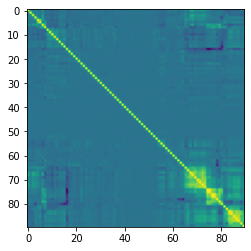

In [9]:
### Correlation ----

def correlation_plot(df, target_encoded):
    """Plot a sorted correlation plot.

    Args:
        df (DataFrame): Source data
        target_encoded (str): Target column
    """
    scaler = StandardScaler()
    df_ = df.drop(target_encoded, axis=1).select_dtypes(exclude=['object'])
    df_ = scaler.fit_transform(df_)
    cov = np.cov(df_, rowvar=False)
    order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype="int")

    plt.imshow(cov[order, :][:, order])

# https://stackoverflow.com/a/63536382/3780957
def correlation_threshold(x: pd.DataFrame, bound: float):
    """Filters the provided DataFrame based on the threshold defined at 'bound' parameter.

    Args:
        x (pd.DataFrame): Source DataFrame
        bound (float): Threshold to limit the correlation.

    Returns:
        DataFrame: Filtered DataFrame
    """
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

def correlation_filter(df, threshold=0.99):
    """Filters data based on the correlation.

    Args:
        df (DataFrame): Source data
        threshold (float, optional): Threshold for the filter. Defaults to 0.99.

    Returns:
        DataFrame: Same as source
    """
    cor_ = correlation_threshold(df, threshold)
    df.drop(cor_.reset_index()['level_1'], axis=1, inplace=True)
    return df


# https://stackoverflow.com/a/25733562/3780957

if full_execution:
    correlation_plot(df, target_encoded)    
print('Correlation filter')
print(f'Shape before {df.shape}')
df = correlation_filter(df, .99)
print(f'Shape after {df.shape}')


 ## SymbolicTransformer
 This method presented in class, transform and creates features using multiple operations. This will add new features to the data frame.

In [10]:
### SymbolicTransformer ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 4 - Feature Engineering\FE BlindCredit example (original 2).ipynb

def symbolic_transformer(X, y, encoder=None):
    """Transform features using multiple operations. This will add new features to the data frame.

    Args:
        X (DataFrame): Independent features
        y (Series): Dependen feature or target
        encoder (obj, optional): Object of the type 'SymbolicTransformer'. Defaults to None.

    Returns:
        DataFrame: Additional columns calculated by the algorithm
    """
    if encoder is None:
        function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                        'abs', 'neg', 'inv', 'max', 'min']
        encoder = SymbolicTransformer(generations=10,
                                population_size=1000,
                                hall_of_fame=100,
                                n_components=12,
                                function_set=function_set,
                                parsimony_coefficient=0.0005,
                                max_samples=0.9,
                                verbose=1,
                                random_state=123,
                                n_jobs=-1)
        encoder.fit(X, y)
    gp_features = encoder.transform(X)

    return gp_features, encoder

def symbolic_transformer_fit(df, encoder=None):
    """Application of the 'SymbolicTransformer' in our data model

    Args:
        df (DataFrame): Source data
        encoder (obj, optional): Object from the type 'SymbolicTransformer'. Defaults to None.

    Returns:
        DataFrame: Same as source
        encoder: Object from the type 'SymbolicTransformer'
        columns: list of additional columns created
    """
    gp_features, enc_gp = symbolic_transformer(df.drop(target_encoded, axis=1), df[target_encoded], encoder)

    columns_ = df.columns

    df_new_features = pd.DataFrame(gp_features)
    df_new_features.columns = ['gp{}'.format(i) for i in range(len(list(df_new_features)))]

    df = pd.concat([df.reset_index().drop(columns="index"), df_new_features], axis=1)

    return df, enc_gp, columns_

df, enc_gp, columns_symbolic = symbolic_transformer_fit(df)



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.99        0.0673699        3         0.372974         0.366299     59.45s
   1     6.34         0.207842        5          0.45943         0.466954     36.62s
   2     3.97         0.315455        3         0.542286         0.530302     27.90s
   3     4.82          0.36401        5         0.542772         0.525791     21.67s
   4     3.51         0.458494        3          0.54298         0.523729     18.54s
   5     3.00          0.47523        3         0.543045         0.523062     13.46s
   6     3.02          0.47683        3         0.542944         0.524208     10.14s
   7     3.04         0.485546        3         0.543417         0.519812      7.31s
   8     3.02         0.472909        3         0.543037         0.523503  

In [11]:
## Feature importance ----


 # Feature importance
 In the following section we will select the most relevant features. These will be source for our ML model.
 ## RelieF Algorithm
 Let's use an implementation of RELIEF algorithm that we can find [here](https://github.com/EpistasisLab/scikit-rebate). We will simply specify how many neighbours to consider when comparing each feature with the rest, to measure differences, and how many features do we want at the end of the process.<br>
 The only caveat is the algorithm expects the values as Numpy arrays with shapes $(m, p)$ for the features ($m$ is the number of tuples/samples and $p$ is the number of predictors/features), and $(m, 1)$ for the target variable (a 1D numpy array, for which we must use the function `ravel()` from Numpy).

In [12]:
### ReliefF ranking ----
# C:\Users\R100983\OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 3\Notebooks on feature engineering\feature importance.ipynb
# Feature importance
# Filters

def plot_importance(features: List[str], importances: List[float]):
    """Plot the variable importance of the data frame

    Args:
        features (List[str]): Features to be included in the plot
        importances (List[float]): Float of the value importance per feature
    """

    num_features = len(features)
    indices = np.argsort(importances)

    plt.figure(figsize=(8, 10))
    plt.title("Feature importances")
    plt.barh(range(num_features), importances[indices],
             color="r",
             xerr=np.std(importances),
             align="center")
    plt.yticks(range(num_features), features[indices])
    plt.ylim([-1, num_features])
    plt.show()

def importance_relieff(X, y, n_features_to_select, n_neighbors, sample_rows, encoder=None, plot=True):
    """Utilization of the algorithm ReliefF in our dataframe

    Args:
        X (DataFrame): Independent variables
        y (Series): Dependen variable or target
        n_features_to_select (int): Number of features to be in the resulting DataFrame
        n_neighbors (int): Number of neighbors to be condered for the model
        sample_rows (int): Number of sample rows
        encoder (obj, optional): Object from the type 'ReliefF'. Defaults to None.
        plot (bool, optional): Controls to show or not the 'plot_importance'. Defaults to True.

    Returns:
        DataFrame: Same as source
    """

    sample = random.sample(list(X.index), sample_rows)
    sample_features = X.iloc[sample, :].to_numpy()
    sample_labels = y.iloc[sample].to_numpy()

    if encoder is None:
        encoder = ReliefF(n_features_to_select=n_features_to_select, n_neighbors=n_neighbors)
        encoder.fit(sample_features, sample_labels)
    my_important_features = encoder.transform(sample_features)

    print("No. of tuples, No. of Columns before ReliefF : "+str(sample_features.shape)+
        "\nNo. of tuples, No. of Columns after ReliefF : "+str(my_important_features.shape))

    # Plot the importances, taken from the `encoder` variable.
    if plot:
        plot_importance(X.columns, abs(encoder.feature_importances_))

    # Get the most important column names
    my_important_features_names  = [X.columns[i] for i in abs(encoder.top_features_)]

    # Create a DataFrame
    X = pd.DataFrame(X, columns=my_important_features_names[:my_important_features.shape[1]])

    return X, encoder


def importance_relieff_fit(df, target_encoded, encoder=None, plot=True):
    """Implementation of the algorithm 'ReliefF'.

    Args:
        df (DataFrame): Source data
        target_encoded (str): Target column name
        encoder (obj, optional): Object of the type 'ReliefF'. Defaults to None.
        plot (bool, optional): Controls to show or not the 'plot_importance'. Defaults to True.

    Returns:
        DataFrame: Same as source
        encoder: Object of the type 'ReliefF'
        columns: List of columns in the resulting data frame 
    """
    X = df.drop(target_encoded, axis=1)
    y = df[target_encoded]
    X_transformed, encoder = importance_relieff(X, y, n_features_to_select=60, n_neighbors=20, sample_rows=1000, encoder=encoder, plot=plot)
    df = pd.concat([X_transformed.reset_index().drop(columns="index"), y.reset_index().drop(columns="index")], axis=1)
    columns_ = df.columns
    return df, encoder, columns_

# This filter is not being used. Because the 'accuracy' is better without this filter.
# df, enc_relieff, columns_relieff = importance_relieff_fit(df, target_encoded)
# TODO: Relieff deactivated


 ## PCA
 The following is an implementation of the `Principal Component Analysis`.<br>
 After some testing and measuring the performance of our model, we decided to not include the `PCA` in the final preprocessing pipeline.

In [13]:
### PCA ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 9 - Forum - Dimensionality Reduction\Notebook on PCA\PCA_v2.ipynb

name = "Accent"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

def pca_transform(data, target, n=2, encoder=None):
    """Applies the principal component algorithm to the data frame.

    Args:
        data (DataFrame): Source data
        target (str): Column name
        n (int, optional): Number of components to be calculated. Defaults to 2.
        encoder (obj, optional): Object of the type 'PCA'. Defaults to None.

    Returns:
        DataFrame: Same as source
        List: Variance explained by each PC.
        Encoder: Object of the type 'PCA'
    """
    if encoder is None:
        encoder = PCA(n_components=n)
        encoder = encoder.fit(data.drop([target], axis=1))
    principalComponents = encoder.transform(data.drop([target], axis=1))
    explained_pca = encoder.explained_variance_ratio_

    data_pca1 = pd.DataFrame(data=principalComponents).reset_index().drop(columns="index")
    data_pca2 = data[target].reset_index().drop(columns="index")
    data_pca = pd.concat([data_pca1, data_pca2], axis=1)

    # Setting columns name
    columns = [f"PC{s}" for s in range(1, n + 1)]
    columns.append(target)
    data_pca.columns = columns

    return data_pca, explained_pca, encoder

# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
def pca_plot_scatter(data, target, axis1=1, axis2=2):
    """Plots the PCA using a scatter plot.

    Args:
        data (DataFrame): Source data
        target (str): Target column name
        axis1 (int, optional): Number of the PC to be plotted. Defaults to 1.
        axis2 (int, optional): Number of the PC to be plotted. Defaults to 2.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(f"Principal Component {axis1}", fontsize=15)
    ax.set_ylabel(f"Principal Component {axis2}", fontsize=15)
    ax.set_title("Component PCA", fontsize=20)
    targets = data[target].unique()
    for target_, color in zip(targets, colors):
        indicesToKeep = data[target] == target_
        ax.scatter(
            data.loc[indicesToKeep, f"PC{axis1}"],
            data.loc[indicesToKeep, f"PC{axis2}"],
            color=color,
            s=50,
        )
    ax.legend(targets)
    ax.grid()

def pca_plot_density(data, target):
    """Plots the PCA using densities

    Args:
        data (DataFrame): Source data
        target (str): Target column name
    """
    categories = data[target].unique()
    category_series = data[target]

    fig, axs = plt.subplots(3, 3)
    fig.set_size_inches(14, 10)

    feature_names = list(set(data.columns) - set([target]))

    for subplot, feature in enumerate(feature_names):
        x, y = int(subplot / 3), subplot % 3
        for value in data[target].unique():
            sns.distplot(
                data[feature][category_series == value],
                hist=False,
                kde=True,
                kde_kws={"shade": True},
                label=str(value),
                ax=axs[x, y],
            )
        axs[x, y].set_title(feature)

    plt.tight_layout()
    plt.show()


In [14]:
# TODO: PCA deactivated, because it is not improving the accuracy of the model to use this technique for dimensionality reduction.
# df_pca, df_explained_variance, enc_pca = pca_transform(data=df, target=target_encoded, n=7)
# print(df_explained_variance.round(2))
# pca_plot_scatter(data=df_pca, target=target_encoded, axis1=1, axis2=2)


 ## Outliers
 In the following section, we filter `outliers` datapoint.<br>
 Particularly, we use the algorithm `IsolationForest`.

In [15]:
### Outliers ----

def outliers_isolation_forest(df, target_encoded, encoder=None, contamination=0.001):
    """Using 'Isolation Forest', filters the outliers data points

    Args:
        df (DataFrame): Source data
        target_encoded (str): Target column name
        encoder (obj, optional): Object of the type 'IsolationForest'. Defaults to None.
        contamination (float, optional): Threshold to remove the outliers. Defaults to 0.001.

    Returns:
        DataFrame: Same as source
    """
    if encoder is None:
        encoder = IsolationForest(contamination=contamination)
        y_pred = encoder.fit(df.drop([target_encoded], axis=1))
    y_pred = encoder.predict(df.drop([target_encoded], axis=1))
    mask = y_pred != -1
    df = df.loc[list(mask), :]
    return df, encoder

print(f'Shape before {df.shape}')
df, enc_outliers = outliers_isolation_forest(df, target_encoded)
print(f'Shape after {df.shape}')


Shape before (82672, 102)
Shape after (82589, 102)


In [16]:
## Training model ----


 # Training model
 We have no mayor problems to create the training dataset, because we have `balanced` target.<br>
 Follwing, different **machine learning** models will be tested. We will select the one that provides us the highest `accuracy`.

## Auxiliary functions
 The following functions were included as helpers for the training, plot and timing.

In [17]:
### Auxiliary functions ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 5 - EvaluationMetrics\Evaluation and Validation.ipynb

def plot_scores(scores, labels):
    """
    Receives scores (one or several arrays) and plots a scatter to the left with
    the values of the first one, and a boxplot with all of them to the right.
    
    Arguments
        scores: single list of scores, or list of lists of scores.
        labels: single label or list of labels identifying the scores passed
    """
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Scores from {}.'.format(labels[0]))
    plt.scatter(range(len(scores[0])), scores[0])
    plt.axhline(np.median(scores[0]), color='orange', linestyle='--', linewidth=0.5)
    
    plt.subplot(1, 2, 2)
    plt.title('{} scores stdev={:.4f}'.format(labels[0], np.std(scores[0])))
    for i in range(len(scores)):
        plt.axhline(np.median(scores[i]), color='orange', 
                    linestyle='--', linewidth=0.5)
    plt.boxplot(scores, labels=labels)
    plt.ylim(bottom=0.6, top=1.0)
    
    plt.show()

def timer(start_time=None):
    """Create a 'timer' object to measure execution time 

    Args:
        start_time (datetime[64], optional): End time when set. Defaults to None.

    Returns:
        str: Time elapsed since execution
    """
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

X = df.drop([target_encoded], axis=1)
y = df[target_encoded]


 ## LogisticRegression
 The first model we are going to train is `LogisticRegression`.<br>
 It does not have any relevant tunning parameter.

Accuracy: 0.7581 (+/- 0.01)


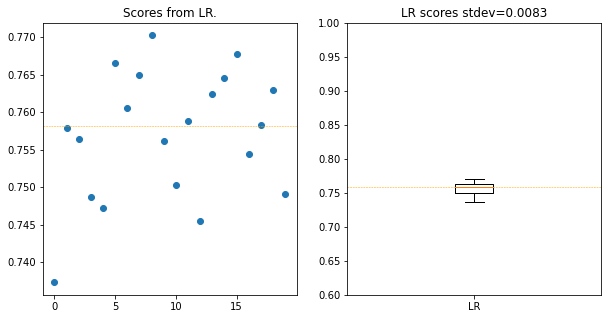

In [18]:
### LogisticRegression ----
lr_model = LogisticRegression()
lr_scores = cross_val_score(lr_model, X, y, scoring='accuracy', cv=20, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(lr_scores), np.std(lr_scores)))
plot_scores([lr_scores], ['LR'])


 ## RandomForestClassifier
 We also trained the `RandomForestClassifier` using the default parameters. This is a random forest classifier.

Accuracy: 0.8443 (+/- 0.00)


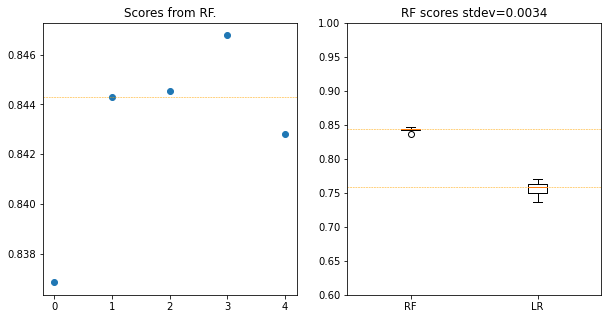

In [19]:
### RandomForestClassifier ----
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_model = RandomForestClassifier(max_depth=100, random_state=0, n_jobs=-1)
rf_scores = cross_val_score(rf_model, X, y, scoring='accuracy', cv=5)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(rf_scores), np.std(rf_scores)))
plot_scores([rf_scores, lr_scores], ['RF', 'LR'])


 ### Hyperparameter tunning `RandomForestClassifier`, grid search
 Having such impressive results from this algorithm, we are tunning the hyperparameters. In particular, we are using `GridSearchCV` with a `cross validation`.

In [20]:
#### Hyperparameter tunning RandomForestClassifier, grid search ----

params = {'max_depth': [None, 43, 44, 45, 46, 47, 48]}
cv_ = 3

rf_model_grid = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_model_search = GridSearchCV(rf_model_grid, param_grid=params, scoring='accuracy', n_jobs=-1, cv=cv_, verbose=3)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
rf_model_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:   29.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:   30.7s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   40.1s finished

 Time taken: 0 hours 0 minutes and 43.4 seconds.


 Checking the accuracy of the best model

Accuracy: 0.8519 (+/- 0.00)


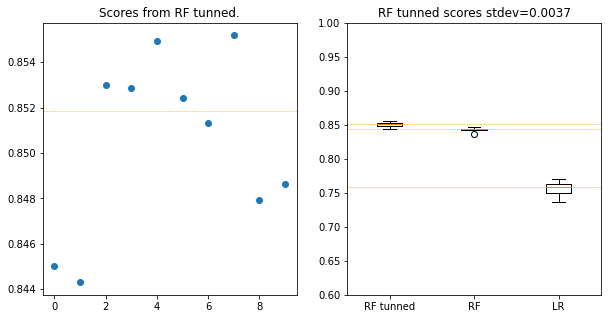

In [21]:
# Checking the accuracy of the best model

rf_model_after_search = rf_model_search.best_estimator_
rf_model_after_search_scores = cross_val_score(rf_model_after_search, X, y, scoring='accuracy', cv=10, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(rf_model_after_search_scores), np.std(rf_model_after_search_scores)))
# plot_scores([xgb_scores_tunned], ['XGB tunned'])
plot_scores([rf_model_after_search_scores, rf_scores, lr_scores], ['RF tunned', 'RF', 'LR'])


 ## KNeighborsClassifier
 We tried `KNeighborsClassifier`. Classifier implementing the k-nearest neighbors vote.

Accuracy: 0.7847 (+/- 0.00)


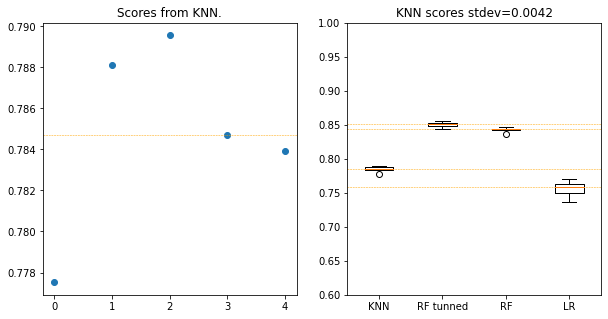

In [22]:
### KNeighborsClassifier ----
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

knn_model = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn_scores = cross_val_score(knn_model, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(knn_scores), np.std(knn_scores)))
plot_scores([knn_scores, rf_model_after_search_scores, rf_scores, lr_scores], ['KNN', 'RF tunned', 'RF', 'LR'])


 ### Hyperparameter tunning KNeighborsClassifier, grid search
 As before, because this algorithm performs so well, we tried to improve the `accuracy`, by doing a computing intensive hyperparameter tunning.<br>
 We implemented a `grid search` to find the best performing parameter.

In [23]:
#### Hyperparameter tunning KNeighborsClassifier, grid search ----

params = {'n_neighbors': range(1, 10)}
cv_ = 3

knn_model_grid = KNeighborsClassifier(n_jobs=-1)
knn_model_search = GridSearchCV(knn_model_grid, param_grid=params, scoring='accuracy', n_jobs=-1, cv=cv_, verbose=3)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
knn_model_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  27 | elapsed:  6.4min remaining: 22.4min
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  9.3min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 15.0min finished

 Time taken: 0 hours 15 minutes and 10.59 seconds.


Accuracy: 0.8510 (+/- 0.00)


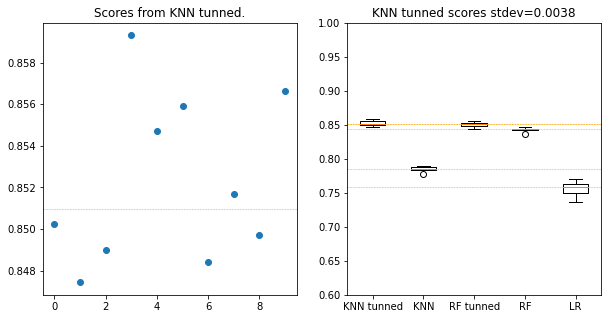

In [24]:
# Checking the accuracy of the best model

knn_model_after_search = knn_model_search.best_estimator_
knn_model_after_search_scores = cross_val_score(knn_model_after_search, X, y, scoring='accuracy', cv=10, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(knn_model_after_search_scores), np.std(knn_model_after_search_scores)))
plot_scores([knn_model_after_search_scores, knn_scores, rf_model_after_search_scores, rf_scores, lr_scores], ['KNN tunned', 'KNN', 'RF tunned', 'RF', 'LR'])


 ## GradientBoostingClassifier
 Gradient Boosting for classification.<br>
 GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.<br>
 Considering the poor results, we don't persue a hyperparameter tunning.

Accuracy: 0.7635 (+/- 0.01)


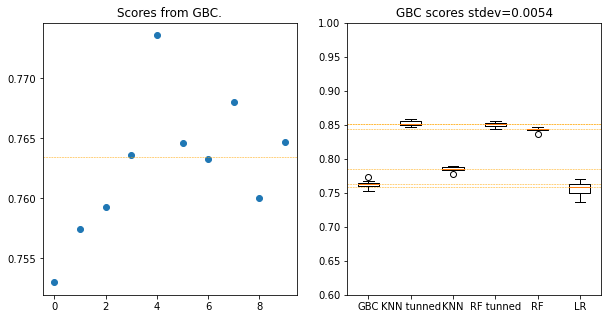

In [25]:
### GradientBoostingClassifier ----
# "OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 6 - Forum\5 Friday\Tree based methods.ipynb"
# https://stackoverflow.com/questions/41567895/will-scikit-learn-utilize-gpu
# https://rapids.ai/xgboost.html

gbc_model = GradientBoostingClassifier(random_state=0)
gbc_scores = cross_val_score(gbc_model, X, y, scoring='accuracy', cv=10)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(gbc_scores), np.std(gbc_scores)))
plot_scores([gbc_scores, knn_model_after_search_scores, knn_scores, rf_model_after_search_scores, rf_scores, lr_scores], ['GBC', 'KNN tunned', 'KNN', 'RF tunned', 'RF', 'LR'])


 ## XGBoost
 XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. <br>
 We had set the library to run in `GPU` to increase tunning performance.<br>
 The performance is very good. We will try hyperparameter tunning.<br>
 More about XGBoost at the [link](https://xgboost.readthedocs.io/en/latest/).

Accuracy: 0.7834 (+/- 0.01)


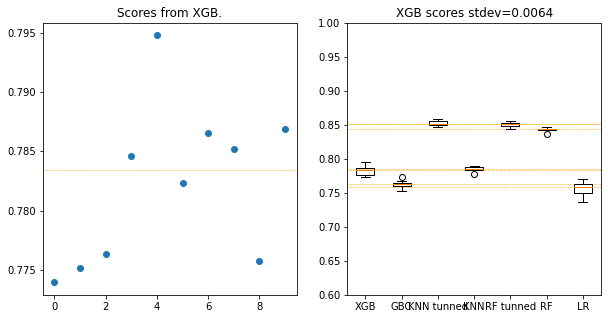

In [26]:
### XGBoost ----
# https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, tree_method='gpu_hist', gpu_id=0, learning_rate=0.02, n_estimators=600, nthread=-1)
xgb_scores = cross_val_score(xgb_model, X, y, scoring='accuracy', cv=10)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(xgb_scores), np.std(xgb_scores)))
plot_scores([xgb_scores, gbc_scores, knn_model_after_search_scores, knn_scores, rf_model_after_search_scores, rf_scores, lr_scores], \
    ['XGB', 'GBC', 'KNN tunned', 'KNN', 'RF tunned', 'RF', 'LR'])


 ### Hyperparameter tunning XGBoost, random search
 Five different parameters will be tunned using random search.<br>
 The performance of this algorithm hasn't improved. For speeding up this *notebook*, we had reduced the number of *parameter combination*.

In [27]:
#### Hyperparameter tunning XGBoost, random search ----
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
# https://xgboost.readthedocs.io/en/latest/gpu/

params = {
        'min_child_weight': [None, 1, 5, 10],
        'gamma': [None, 0.5, 1, 1.5, 2, 5],
        'subsample': [None, 0.6, 0.8, 1.0],
        'colsample_bytree': [None, 0.6, 0.8, 1.0],
        'max_depth': [None, 3, 4, 5]
        }

folds = 3
param_comb = 5
cv_ = 3

xgb_model_random = xgb.XGBClassifier(objective="binary:logistic", random_state=42, tree_method='gpu_hist', gpu_id=0, learning_rate=0.02, n_estimators=600, nthread=-1)
xgb_model_search = RandomizedSearchCV(xgb_model_random, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=cv_, verbose=3, random_state=42)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_model_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   44.8s remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   53.9s remaining:   47.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished

 Time taken: 0 hours 1 minutes and 12.25 seconds.


Accuracy: 0.7839 (+/- 0.01)


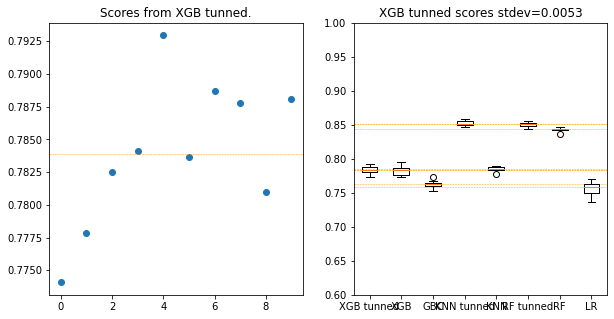

In [28]:
# https://stackoverflow.com/a/45074887/3780957
# Checking the accuracy of the best model

xgb_model_after_search = xgb_model_search.best_estimator_
xgb_scores_tunned = cross_val_score(xgb_model_after_search, X, y, scoring='accuracy', cv=10)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(xgb_scores_tunned), np.std(xgb_scores_tunned)))
plot_scores([xgb_scores_tunned, xgb_scores, gbc_scores, knn_model_after_search_scores, knn_scores, rf_model_after_search_scores, rf_scores, lr_scores], \
    ['XGB tunned', 'XGB', 'GBC', 'KNN tunned', 'KNN', 'RF tunned', 'RF', 'LR'])


 ### Hyperparameter tunning XGBoost, grid search
 We also tried `grid search` with no better results.<br>
 To speed up the evaluation time of the *notebook*, we had commented this *cell*.

In [29]:
#### Hyperparameter tunning XGBoost, grid search ----
# Removed because of the computing time

# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

# params = {
#         'min_child_weight': [None, 1, 5, 10],
#         'gamma': [None, 0.5, 1, 5],
#         'subsample': [None, 0.6, 1.0],
#         'colsample_bytree': [None, 0.6, 1.0],
#         'max_depth': [None, 3, 5]
#         }

# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, tree_method='gpu_hist', gpu_id=0, learning_rate=0.02, n_estimators=600, )
# xgb_model_grid_search = GridSearchCV(xgb_model, param_grid = params, cv = 3, verbose=3)

# start_time = timer(None)
# xgb_model_grid_search.fit(X, y)
# timer(start_time)


 # Testing dataset
 The following chunks of code, will test the previously trained model, using a subset of the dataset.<br>
 The subset was extracted from `modeling_set.csv`.<br>
 As mentioned before, the *testing* dataset has been reduced in size to improve the performance for the final assignment validation `accuracy`.

In [30]:
## Testing dataset ----
# df_val


 ## Preprocessing
 We applied the previously **preprocessing** defined workflow.<br>
 Some of the steps done before, does not apply for a *validation* dataset. Those are commented.
## Preprocessing ----
 Remove and filtering
 Does not apply
 TargetEncoder

In [31]:
df_val, _ = label_encoder(df_val, map_, map_encoded, enc_le_map)
df_val, _ = label_encoder(df_val, target, target_encoded, enc_le_target)
# TargetRobustScalerEncoder
columns_scaler
df_val, _, _ = scaler(df_val.loc[:, columns_scaler], target_encoded, enc_scaler)
# Correlation
# SymbolicTransformer
df_val, _, _ = symbolic_transformer_fit(df_val.loc[:, columns_symbolic], enc_gp)
# ReliefF ranking
# df_val = df_val.loc[:, columns_relieff]
# PCA
# df_pca, _, _ = pca_transform(data=df_val, target=target_encoded, n=7, encoder=enc_pca)
# Outliers
# Does not apply


In [32]:

X_val = df_val.drop([target_encoded], axis=1)
y_val = df_val[target_encoded]


 ## Model predict
 The following lines of code, are using the models for prediction.<br>
 We are using `cross_val_score` to asses the model performance.

# Validation dataset
 The class validation will be done using the following dataset `modeling_set.csv`.<br>
 Here, we also applied the *preprocessing* and the different models to test the performance.

In [34]:
## Validation dataset ----


 ## Loading data
 Loading the previously mentioned `validation_set.csv`.

In [35]:
### Loading data ----
df_validation = pd.read_csv('raw/validation_set.csv')


In [36]:
### Preprocessing ----

# Column type casting
df_validation['bomb_planted'] = 1.*df_validation['bomb_planted']
# Remove and filtering
# Does not apply
# TargetEncoder
df_validation, _ = label_encoder(df_validation, map_, map_encoded, enc_le_map)
df_validation, _ = label_encoder(df_validation, target, target_encoded, enc_le_target)
# TargetRobustScalerEncoder
columns_scaler
df_validation, _, _ = scaler(df_validation.loc[:, columns_scaler], target_encoded, enc_scaler)
# Correlation
# SymbolicTransformer
df_validation, _, _ = symbolic_transformer_fit(df_validation.loc[:, columns_symbolic], enc_gp)
# ReliefF ranking
# df_validation = df_validation.loc[:, columns_relieff]
# PCA
# df_pca, _, _ = pca_transform(data=df_validation, target=target_encoded, n=7, encoder=enc_pca)
# Outliers
# Does not apply

X_validation = df_validation.drop([target_encoded], axis=1)
y_validation = df_validation[target_encoded]


Accuracy: 0.7465 (+/- 0.01)


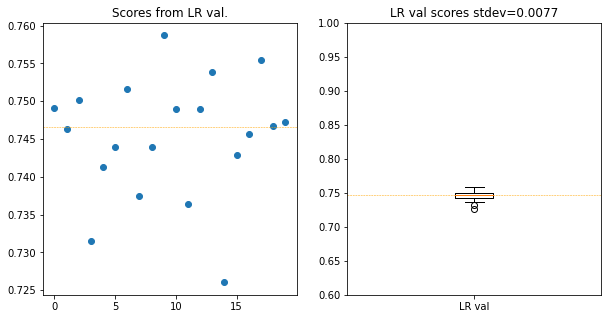

In [37]:
### Model predict ----

lr_scores_validation = cross_val_score(lr_model, X_validation, y_validation, scoring='accuracy', cv=20, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(lr_scores_validation), np.std(lr_scores_validation)))
plot_scores([lr_scores_validation], ['LR val'])


Accuracy: 0.7753 (+/- 0.0063)


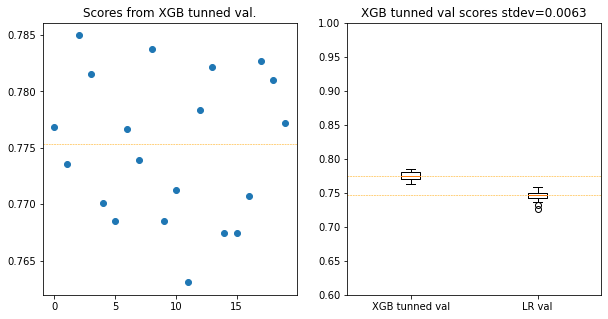

In [38]:
xgb_scores_tunned_validation = cross_val_score(xgb_model_after_search, X_validation, y_validation, scoring='accuracy', cv=20, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.4f)" % (np.median(xgb_scores_tunned_validation), np.std(xgb_scores_tunned_validation)))
plot_scores([xgb_scores_tunned_validation, lr_scores_validation], ['XGB tunned val', 'LR val'])


Accuracy: 0.8135 (+/- 0.0074)


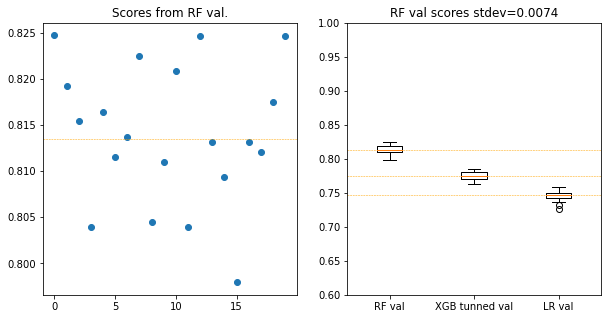

In [39]:
rf_scores_validation = cross_val_score(rf_model, X_validation, y_validation, scoring='accuracy', cv=20, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.4f)" % (np.median(rf_scores_validation), np.std(rf_scores_validation)))
plot_scores([rf_scores_validation, xgb_scores_tunned_validation, lr_scores_validation], ['RF val', 'XGB tunned val', 'LR val'])


Accuracy: 0.8129 (+/- 0.0087)


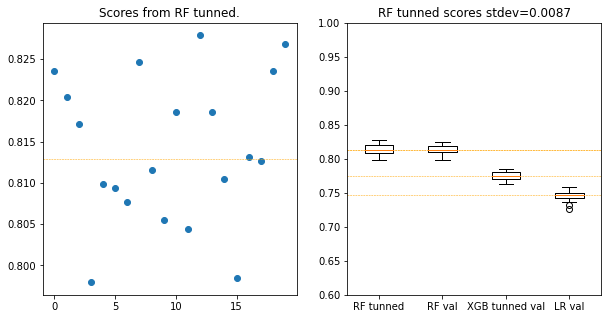

In [40]:
rf_scores_tunned_validation = cross_val_score(rf_model_after_search, X_validation, y_validation, scoring='accuracy', cv=20, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.4f)" % (np.median(rf_scores_tunned_validation), np.std(rf_scores_tunned_validation)))
plot_scores([rf_scores_tunned_validation, rf_scores_validation, xgb_scores_tunned_validation, lr_scores_validation], ['RF tunned', 'RF val', 'XGB tunned val', 'LR val'])


Accuracy: 0.7702 (+/- 0.0070)


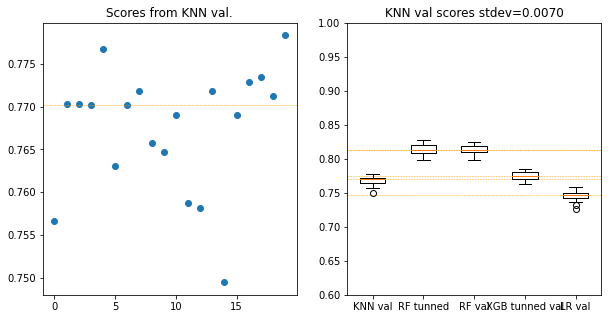

In [43]:
knn_scores_validation = cross_val_score(knn_model, X_validation, y_validation, scoring='accuracy', cv=20, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.4f)" % (np.median(knn_scores_validation), np.std(knn_scores_validation)))
plot_scores([knn_scores_validation, rf_scores_tunned_validation, rf_scores_validation, xgb_scores_tunned_validation, lr_scores_validation], ['KNN val', 'RF tunned', 'RF val', 'XGB tunned val', 'LR val'])


Accuracy: 0.8088 (+/- 0.0093)


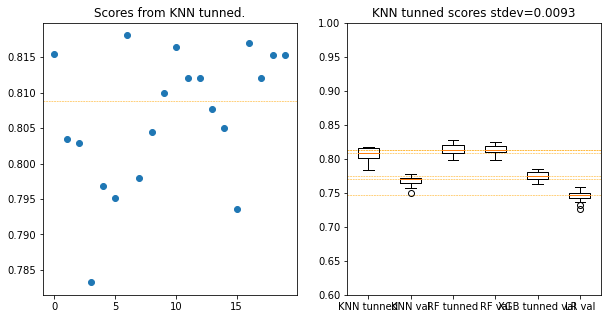

In [44]:
knn_scores_tunned_validation = cross_val_score(knn_model_after_search, X_validation, y_validation, scoring='accuracy', cv=20, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.4f)" % (np.median(knn_scores_tunned_validation), np.std(knn_scores_tunned_validation)))
plot_scores([knn_scores_tunned_validation, knn_scores_validation, rf_scores_tunned_validation, rf_scores_validation, xgb_scores_tunned_validation, lr_scores_validation], ['KNN tunned', 'KNN val', 'RF tunned', 'RF val', 'XGB tunned val', 'LR val'])


# Storing the models

In [60]:
### Model save ----
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

filename = 'storage/lr_model.sav'
pickle.dump(lr_model, open(filename, 'wb'))

filename = 'storage/xgb_model_after_search.sav'
pickle.dump(xgb_model_after_search, open(filename, 'wb'))

filename = 'storage/rf_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

filename = 'storage/rf_model_after_search.sav'
pickle.dump(rf_model_after_search, open(filename, 'wb'))

filename = 'storage/knn_model.sav'
pickle.dump(knn_model, open(filename, 'wb'))

filename = 'storage/knn_model_after_search.sav'
pickle.dump(knn_model_after_search, open(filename, 'wb'))


 ## Prediction
 Prediction using our best model.

In [61]:
### Prediction ----
prediction_ = rf_model_after_search.predict(X_validation)
prediction_ = enc_le_target.inverse_transform(prediction_)

np.savetxt("results/prediction.csv", prediction_, delimiter=",", fmt='%s')